<a href="https://colab.research.google.com/github/ShriramGithub7/EVA_Custom_ResNet/blob/main/custom_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [27]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu2(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()

        self.preplayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResBlock(128, 128)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            ResBlock(512, 512)
        )

        self.pool = nn.MaxPool2d(kernel_size=4, stride=4)

        self.fc = nn.Linear(512, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.preplayer(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.softmax(out)

        return out


In [28]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [5]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def viz_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = exp[i]

    figure.add_subplot(rows, cols, i)
    plt.title(exp.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

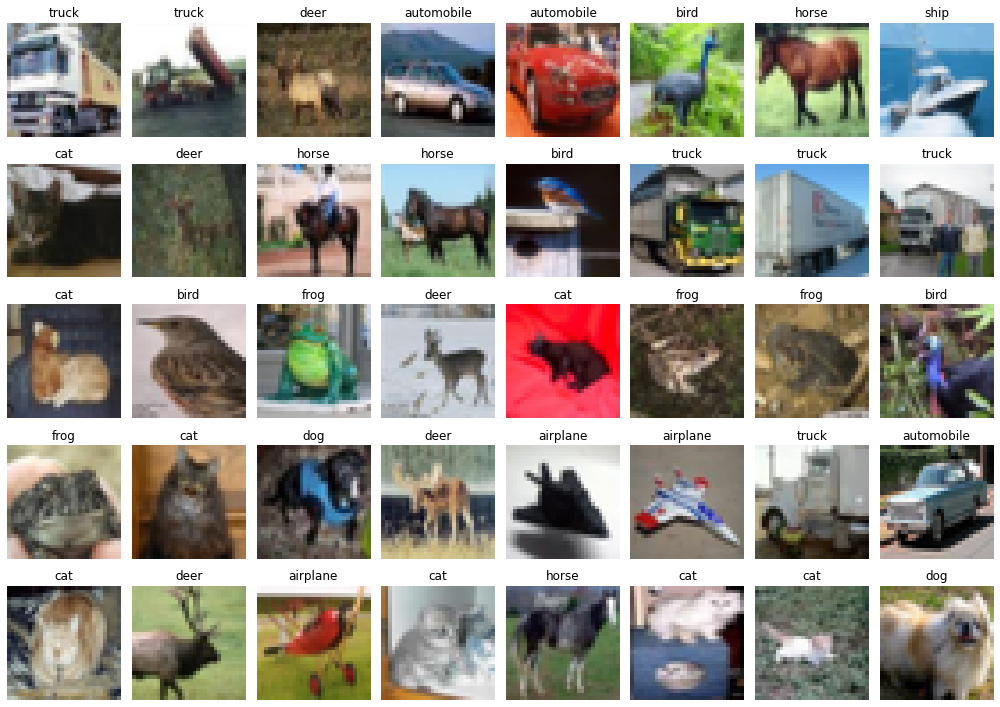

In [7]:
viz_data()

In [8]:
def show_images(aug_dict, ncol=6):
  nrow = len(aug_dict)

  fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
  for i, (key, aug) in enumerate(aug_dict.items()):
    for j in range(ncol):
      ax = axes[j,i]
      if j == 0:
        ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
      else:
        image, label = exp[j-1]
        if aug is not None:
          transform = A.Compose([aug])
          image = np.array(image)
          image = transform(image=image)['image']
          
        ax.imshow(image)
        ax.set_title(f'{exp.classes[label]}')
        ax.axis('off')

  plt.tight_layout()
  plt.show()

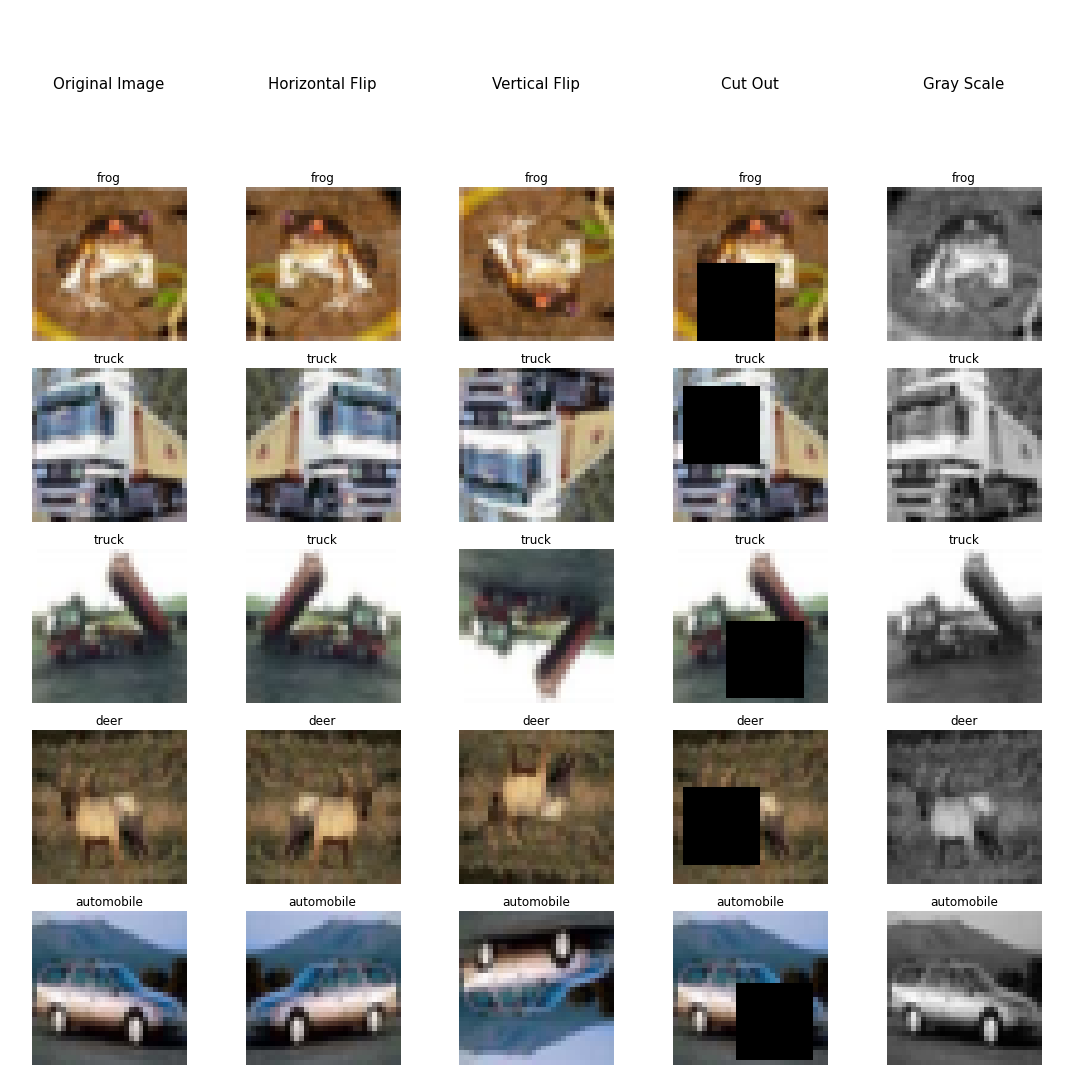

In [9]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [29]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.PadIfNeeded(min_height=36, min_width=36),
          A.RandomCrop(height=32, width=32),
          A.HorizontalFlip(p=0.5),
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_height=8, min_width=8, fill_value=0.473363, mask_fill_value=None),
          A.ToGray(),
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [30]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


In [31]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = CustomResNet().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1,

In [33]:
def train(model, device, train_loader, optimizer, l1, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  num_loops = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1 = 0
    lambda_l1 = 0.01
    if l1:
      for p in model.parameter():
        l1 = l1 + p.abs().sum()
    
    loss = loss + lambda_l1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    num_loops += 1
    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100*correct/processed:0.2f}')
  
  return 100*correct/processed, train_loss/num_loops

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    return 100. * correct / len(test_loader.dataset), test_loss

def fit_model(net, NUM_EPOCHS=24, l1=False, l2=False):
  training_acc, training_loss, testing_acc, testing_loss = [], [], [], []
  
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  
  # set LRMAX and LRMIN
  max_lr = 0.02
  min_lr = max_lr/10
  
  # set One Cycle Policy scheduler
  num_steps = NUM_EPOCHS * len(train_loader)
  anneal_strategy = 'cos'
  cycle_momentum = True
  max_momentum = 0.95
  base_momentum = 0.85
  step_size_up = int(num_steps * 0.3)
  step_size_down = num_steps - step_size_up
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_steps, anneal_strategy=anneal_strategy, cycle_momentum=cycle_momentum, max_momentum=max_momentum, base_momentum=base_momentum, div_factor=max_lr/min_lr, pct_start=step_size_up/num_steps, steps_per_epoch=len(train_loader))
  
  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      
      # update LRMAX at epoch 5
      if epoch == 5:
          scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_steps, anneal_strategy=anneal_strategy, cycle_momentum=cycle_momentum, max_momentum=max_momentum, base_momentum=base_momentum, div_factor=max_lr/min_lr, pct_start=step_size_up/num_steps, steps_per_epoch=len(train_loader))
      
      train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test(net, device, test_loader)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [34]:
net, history = fit_model(net, NUM_EPOCHS=24)

EPOCH: 1


Batch_id=97 Loss=-0.18925 Accuracy=19.69: 100%|██████████| 98/98 [00:33<00:00,  2.93it/s]



Test set: Average loss: -0.2683, Accuracy: 2860/10000 (28.60%)

EPOCH: 2


Batch_id=97 Loss=-0.31511 Accuracy=33.07: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set: Average loss: -0.3878, Accuracy: 3990/10000 (39.90%)

EPOCH: 3


Batch_id=97 Loss=-0.41806 Accuracy=43.29: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.4549, Accuracy: 4708/10000 (47.08%)

EPOCH: 4


Batch_id=97 Loss=-0.47889 Accuracy=49.12: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.4897, Accuracy: 4976/10000 (49.76%)

EPOCH: 5


Batch_id=97 Loss=-0.52379 Accuracy=53.54: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set: Average loss: -0.5191, Accuracy: 5303/10000 (53.03%)

EPOCH: 6


Batch_id=97 Loss=-0.54128 Accuracy=55.36: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set: Average loss: -0.5350, Accuracy: 5464/10000 (54.64%)

EPOCH: 7


Batch_id=97 Loss=-0.55312 Accuracy=56.31: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Test set: Average loss: -0.5157, Accuracy: 5217/10000 (52.17%)

EPOCH: 8


Batch_id=97 Loss=-0.56310 Accuracy=57.15: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.5468, Accuracy: 5533/10000 (55.33%)

EPOCH: 9


Batch_id=97 Loss=-0.57731 Accuracy=58.54: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.5574, Accuracy: 5624/10000 (56.24%)

EPOCH: 10


Batch_id=97 Loss=-0.58572 Accuracy=59.35: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]



Test set: Average loss: -0.5753, Accuracy: 5809/10000 (58.09%)

EPOCH: 11


Batch_id=97 Loss=-0.59645 Accuracy=60.32: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]



Test set: Average loss: -0.5690, Accuracy: 5759/10000 (57.59%)

EPOCH: 12


Batch_id=97 Loss=-0.60674 Accuracy=61.31: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.5821, Accuracy: 5875/10000 (58.75%)

EPOCH: 13


Batch_id=97 Loss=-0.66654 Accuracy=67.67: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.6473, Accuracy: 6571/10000 (65.71%)

EPOCH: 14


Batch_id=97 Loss=-0.69215 Accuracy=70.11: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: -0.6262, Accuracy: 6322/10000 (63.22%)

EPOCH: 15


Batch_id=97 Loss=-0.70318 Accuracy=71.12: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set: Average loss: -0.6573, Accuracy: 6634/10000 (66.34%)

EPOCH: 16


Batch_id=97 Loss=-0.71140 Accuracy=71.84: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]



Test set: Average loss: -0.6606, Accuracy: 6681/10000 (66.81%)

EPOCH: 17


Batch_id=97 Loss=-0.71817 Accuracy=72.49: 100%|██████████| 98/98 [00:35<00:00,  2.80it/s]



Test set: Average loss: -0.6754, Accuracy: 6814/10000 (68.14%)

EPOCH: 18


Batch_id=97 Loss=-0.72807 Accuracy=73.52: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]



Test set: Average loss: -0.6855, Accuracy: 6898/10000 (68.98%)

EPOCH: 19


Batch_id=97 Loss=-0.73531 Accuracy=74.15: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]



Test set: Average loss: -0.6768, Accuracy: 6846/10000 (68.46%)

EPOCH: 20


Batch_id=97 Loss=-0.76660 Accuracy=77.78: 100%|██████████| 98/98 [00:35<00:00,  2.80it/s]



Test set: Average loss: -0.7010, Accuracy: 7108/10000 (71.08%)

EPOCH: 21


Batch_id=97 Loss=-0.78796 Accuracy=79.85: 100%|██████████| 98/98 [00:35<00:00,  2.80it/s]



Test set: Average loss: -0.7163, Accuracy: 7239/10000 (72.39%)

EPOCH: 22


Batch_id=97 Loss=-0.80137 Accuracy=81.19: 100%|██████████| 98/98 [00:35<00:00,  2.80it/s]



Test set: Average loss: -0.7243, Accuracy: 7306/10000 (73.06%)

EPOCH: 23


Batch_id=97 Loss=-0.81376 Accuracy=82.31: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]



Test set: Average loss: -0.7423, Accuracy: 7505/10000 (75.05%)

EPOCH: 24


Batch_id=97 Loss=-0.82375 Accuracy=83.27: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set: Average loss: -0.7468, Accuracy: 7540/10000 (75.40%)

